# q3dfit notebook: rest-frame optical, JWST/NIRSpec data of J1652 (SDSSJ165202.64+172852.3) from [Wylezalek et al. 2022](https://ui.adsabs.harvard.edu/abs/2022arXiv221010074W/abstract)

<h3><font color='teal'>Installation of the environment and the package are described <a href="https://q3dfit.readthedocs.io/">here</a>. </font></h3>

This Jupyter notebook allows you to run Q3Dfit, a PSF decomposition and spectral analysis package tailored for JWST NIRSpec and MIRI IFU observations. 

Q3Dfit is developed as a science-enabling data product by the Early Release Science Team #1335 Q3D. You can find more information about this ERS program **Q3D** [here](https://wwwstaff.ari.uni-heidelberg.de/dwylezalek/q3d.html) and [here](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1335).

The software is based on the existing package IFSFIT developed by Dave Rupke (see [ADS link](https://ui.adsabs.harvard.edu/abs/2017ApJ...850...40R/abstract)).

The following notebook will guide you through the initialization procedure and will then perform the analysis. 

## Table of Contents

* [1. Initialization](#chapter1)
    * [1.0. Setting up the directory tree](#chapter1_0)
    * [1.1. Setting up the data and models](#chapter1_1)
    * [1.2. Setting up the fitting parameters](#chapter1_2)
        * [1.2.1. Emission line parameters](#chapter1_2_1)
        * [1.2.2. Continuum parameters](#chapter1_2_2)
* [2. Run fitting](#chapter2)
* [3. Plot fit](#chapter3)
* [4. Combine fit results for entire cube](#chapter4)
* [5. Map fit results](#chapter5)

## 1. Initialization <a class="anchor" id="chapter1"></a>

In [1]:
import os.path
import numpy as np
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Be sure to set the path to q3dfit correctly.
# For instance:
#import sys
#sys.path.append('/Users/jwstuser/q3dfit/')
#import sys
#sys.path.append("../")

### 1.0. Setting up the directory tree <a class="anchor" id="chapter1_0"></a>

Define the directories in which the data cube(s) that you want to analyse are stored and the output directories. We recommend creating a working directory that you name after your target, in which all outputs from q3dfit will be saved. Then download test data.

In [3]:
# Base directory (book-keeping)
volume = 'nirspec-j1652/'
# prefix label for output files
label = 'j1652'
# Input directory
indir = volume
if not os.path.exists(indir):
    os.makedirs(indir)
# Output directory
outdir = volume
if not os.path.exists(outdir):
    os.makedirs(outdir)
# Initialization file (q3di.npy) directory
initdir = volume
# Output logfile
logfile = outdir+label+'-fitlog.txt'

Download data from public Box folder:

In [4]:
# make tuples of urls and download filenames
# infile = data cube
infile_tup=('https://rhodes.box.com/shared/static/6555ks61xk73iwat74mexl728bferfcb.fits','nirspec-j1652.fits')
# download files; by default don't force overwrite and take first element of output
from q3dfit.jnb import download_files
infile = download_files(infile_tup, outdir, force=False)[0]
# add subdirectory to filenames
infile = initdir+infile

nirspec-j1652.fits already exists, skipping download...


In [5]:
from q3dfit.q3din import q3din
q3di = q3din(infile, label, datext=0, varext=1, dqext=2, outdir=outdir, logfile=logfile)

In [6]:
q3di.__dict__

{'argsreadcube': {},
 'cutrange': None,
 'infile': 'nirspec-j1652/nirspec-j1652.fits',
 'fitrange': None,
 'label': 'j1652',
 'logfile': 'nirspec-j1652/j1652-fitlog.txt',
 'name': None,
 'outdir': 'nirspec-j1652/',
 'spect_convol': {},
 'vacuum': True,
 'zsys_gas': None,
 'datext': 0,
 'varext': 1,
 'dqext': 2,
 'vormap': None,
 'docontfit': False,
 'dolinefit': False}

### 1.1. Setting up the data and models <a class="anchor" id="chapter1_1"></a>

Some general information about your cube. `argsreadcube` is a dictionary of attributes sent to the `CUBE` class.
- For non-JWST data, set `wmapext` to `None`. The WMAP extension is a [3-D weight image](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html) giving the relative weights of the output spaxels.
- Microns are the wavelength unit used internally, but `q3dfit` can accept other wavelength input units or output other units.
- The code does calculations in flambda space, but assumes input units of MJy/sr, the JWST default. Other input wavelength units can be specified.

In [7]:
q3di.argsreadcube = {'wmapext': None,
                     'fluxunit_out': 'MJy/sr'}
cube = q3di.load_cube()

Size of data cube: [ 89 , 81 , 1843 ]
Wavelength range: [ 1.700016528205231 , 2.429448507097766 ]  micron


In [8]:
cube.convolve(2.5)

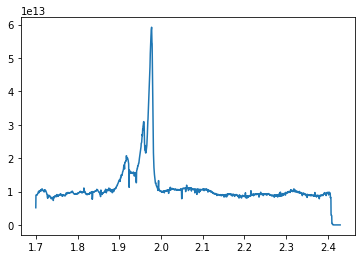

In [9]:
spec_rad2pix = cube.specextract([47.,47.], radius=2.5)

In [10]:
cube.writefits(initdir+'nirspec-j1652-conv.fits')
q3di.infile = initdir+'nirspec-j1652-conv.fits'

In [11]:
q3di.argsreadcube = {'wmapext': None, 
                     'pixarea_sqas': 0.0025, 
                     'fluxnorm': 4e9*1e-17}
cube = q3di.load_cube()

Size of data cube: [ 89 , 81 , 1843 ]
Wavelength range: [ 1.700016528205231 , 2.429448507097766 ]  micron


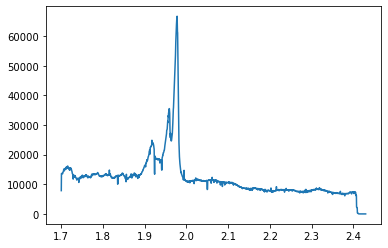

In [12]:
spec_rad2pix = cube.specextract([47.,47.], radius=2.5)

Name and systemic redshift of the galaxy. `zsys` is presently not used within the code, but would be an input for, e.g., calculating velocity maps in routines under development (e.g., `makemaps.py`). It is used in this notebook in initializing the arrays of initial guesses below.

In [13]:
q3di.name = 'J1652'
q3di.zsys_gas = 2.9489

Wavelength range over which to fit data. The user can also specify sets of regions to ignore in the fit.

In [17]:
q3di.fitrange = [1.70, 2.4]
#q3di.cutrange = np.array([,])

Create quasar template from the central spaxel of the spatially-unbinned data cube.

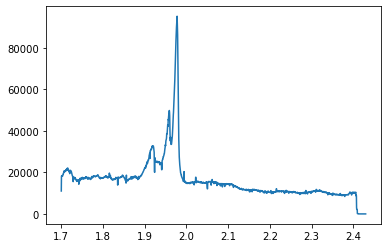

In [18]:
qsotemplate = outdir+'nirspec-j1652-quasar-template.npy'
cube.makeqsotemplate(qsotemplate, radius=2.5)

### 1.2. Setting up the fitting parameters <a class="anchor" id="chapter1_2"></a>

#### 1.2.1. Emission-line parameters <a class="anchor" id="chapter1_2_1"></a>

What lines do you want to fit? You can choose from the linelists available [here](https://github.com/Q3D/q3dfit/tree/main/data/linelists), or in `q3dfit/data/linelists/`. By default the code assumes vacuum wavelengths, but this can be turned off (as it is here for these ground-based data). How many components do you want to be fitted to the emission lines? 

In [19]:
lines = ['Hbeta', '[OIII]4959', '[OIII]5007']

This block sets up initial conditions for the emission-line fit to each spaxel. Emission lines are set to a common redshift and velocity dispersion. However, different sets of emission lines can have different velocities and linewidths by specifying different lines to which to tie particular emission lines.

In [20]:
q3di.init_linefit(lines, linetie='[OIII]5007', maxncomp=3)

In [21]:
for i in lines:
    # narrow, redshifted component
    q3di.zinit_gas[i][:,:,2] = 2.959
    # broad, blueshifted component
    q3di.zinit_gas[i][:,:,1] = 2.9489
    q3di.siginit_gas[i][:,:,1] = 500.

`siglim_gas` sets lower and upper bounds for the Gaussian width (sigma) of the emission line. These limits can be set globablly, for all spaxels and components, by defining a 2-element array. The limits can also be set for individual spaxels (but all components) by defining an (Ncol x Nrow x 2) array.

In [22]:
# Global limit
q3di.siglim_gas = np.array([40., 2000.])

# Spaxel-by-spaxel limit
# siglim_gas = np.ndarray((dx, dy, 2))
# siglim_gas[:,:,] = array([5.,1000.])
# siglim_gas[13, 10, :] = array([5.,500.])

The routine `checkcomp` automatically discards components that it deems insignificant after each fit. It does so with both a significance cut on flux, and if the linewidth is too large. If components are removed, the fit is re-run.

The `sigcut` parameter determines the level of the significance cut. `ignore` is a list of lines to ignore when performing the significance cut.

In [23]:
#q3di.argscheckcomp['sigcut'] = 5.
q3di.checkcomp = False
#q3di.argscheckcomp['ignore']= ['Hbeta']

#### Line ratio constraints
`line1`, `line2`, and `comp` are required. `value` is the initial value of `line1`/`line2`, and `lower` and `upper` limits can also be specified. (If they are not, and the line pair is a doublet in the doublets.tbl file, then the lower and upper limits are set using the data in that file.) The ratio can also be `fixed`.

In [24]:
# Required columns:
#line1 = ['[NI]5198']
#line2 = ['[NI]5200']
#comp = np.array([0], dtype=np.int32)

# Optional columns:
#value = [1.5]
#fixed = [True]
# lower = []
# upper = []

# Write table
#from astropy.table import QTable
#lineratio = QTable([line1, line2, comp, value, fixed], names=['line1', 'line2', 'comp', 'value', 'fixed'])

#q3di.argslineinit['lineratio']=lineratio

#### Spectral resolution convolution
##### Just running convolution ---

If no convolution is desired, then set `spectres_convolve` to None. 
If convolution is desired, then `spectres_convolve` and `spect_instrum` are required variables.

Specify the desired convolution method using `spect_instrum`. The syntax is: 
`spect_instrum = {INSTRUMENT:[METHOD]}`, which should mirror the filename in `q3dfit/data/dispersion_files/`. METHOD specifies the grating, spectral resolution [R], Δλ FWHM in [Å], velocity in [km/s].

Examples convolving with: 
1. flat R=500: `spect_instrum = {'flat':['R500']}`
2. flat velocity FWHM = 30km/s: `spect_instrum = {'flat':['kms30']}`
3. flat Δλ FWHM = 4 Å: `spect_instrum = {'flat':['dlambda4']}`
4. JWST NIRSPEC / G140M: `spect_instrum = {'JWST_NIRSPEC':['G140M']}`

If desired flat convolution file does not exist, then a new file will be created automatically. 

This case applies to the GMOS B600 grating. Gemini website says R = 1688 at 4610 A for 0.5" slit, with IFU 0.31" eff. slit. This gives 1.69 A FWHM. I measure sometimes closer to 1.5-1.6 A.

In [25]:
spect_instrum = {'JWST_NIRSPEC':['G235H']}
q3di.spect_convol['ws_instrum'] = spect_instrum

##### Creating convolution files (optional) ---

If the user wants to create a dispersion file, there are 2 methods:

1. First, run `from q3dfit.common.spectConvol import dispFile` and initialize: `dispObj = dispFile()`
2. Create the files with either method A or B

2.(A) Create a flat R=120 dispersion file from 10 μm to 30 μm: 

`dispObj.make_dispersion(120,WAVELEN=[10,30],TYPE='R')`

2.(B) Create a custom dispersion file with user supplied wavelength and Resolving power lists:

`dispObj.make_custom_dispersion([wavelen list],R=[some R list],FILENAME='custom_RlistA_disp')`

3. Specify desired dispersion file in convolution: running custom example 2B

`spect_instrum = {'custom':['RlistA']}`


In [26]:
#from q3dfit.common.spectConvol import dispFile
#dobj = dispFile()
#dispObj.make_custom_dispersion([wavelen list],R=[some R list],FILENAME='custom_RlistA_disp')
#spect_instrum = {'custom':['RlistA']}

#### Options to `lmfit` and `scipy.optimize.least_squares`
`q3dfit` uses the `fit` method of the [`Model` class](https://lmfit.github.io/lmfit-py/model.html#lmfit.model.Model) of `lmfit` to call [`scipy.optimize.least_squares`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html). Both the method and function have options which can be changed in the `q3dfit` call. To do so, add key/value pairs to the `argslinefit` dictionary, which in turn is a keyword of the `q3di` dictionary.

The options to the `fit` method in `lmfit` that can currently be changed are the following:
- `max_nfev`: maximum number of function evaluations before the fit aborts
- `iter_cb`: if this is set to "per_iteration", the value of every model parameter at each function evaluation is printed to `stdout`

Most parameters of `least_squares` can be changed in this way, unless they are specifically set by `lmfit`. Examples which have been tested include:
- `x_scale`: jac
- `tr_solver`: lsmr
- `loss`: soft_l1
- `ftol`, `gtol`, `xtol`

In [27]:
#q3di.argslinefit['iter_cb'] = 'per_iteration'
# As an example, to change the criteria for fit convergence from the defaults of 1.e-8 to 1.e-10:
# q3di.argslinefit['ftol'] = 1.e-10
# q3di.argslinefit['gtol'] = 1.e-10
# q3di.argslinefit['xtol'] = 1.e-10

#### 1.2.2 Continuum parameters <a class="anchor" id="chapter1_2_2"></a>

`q3dfit` first masks emission lines before fitting. This sets is the default mask value in km/s for each velocity component for the first fit. During the second fit, the mask value is set automatically using the best-fit linewidths determined from the first fit.

The continuum fitting parameters specified here are for the case of simultaneous fitting of a stellar and quasar template.
- `hostord` = [Optional] additive Legendre polynomial for host [starlight] component. Adds components up to order `hostord`. 0 < hostord < 4
- `qsoord` = [Optional] additive Legendre polynomial for host [starlight] component. Adds components up to order `qsoord`. 0 < hostord < 4
- `qsoxdr` = Filename and path of quasar template created earlier with `makeqsotemplate.py`.
- `refit` = Set to `ppxf` to fit (data - quasar) residual with stellar model.
- `blrpar` = Set of initial Gaussian parameters (flux, observed wavelength, sigma in km/s) for fitting empirical scattered-light model (relevant only for narrow set of cases).

Because we are fitting with `ppxf`, we set up initial guesses for stellar velocity and velocity dispersion.

In [28]:
q3di.init_contfit('fitqsohost')

In [29]:
q3di.argscontfit['qsoxdr'] = qsotemplate
q3di.argscontfit['qsoord'] = 3
q3di.argscontfit['hostord'] = 3
q3di.decompose_qso_fit = True

Arguments to `lmfit`

In [30]:
argslmfit = dict()
argslmfit['ftol'] = 1.e-10
argslmfit['gtol'] = 1.e-10
argslmfit['xtol'] = 1.e-10

q3di.argscontfit['argslmfit'] = argslmfit

If you want to run `q3dfit` in batch mode, run this cell, which saves q3di to an `npy` file. In your python command line, read in file and run `q3dfit` with
<pre><code>q3di = '/path/to/the/npy/file/q3di.npy'
from q3dfit.q3df import q3df
q3df(q3di,cols=cols,rows=rows)</code></pre>
N.B.: When running `q3dfit` using multiple cores (`ncores=N` in the call to `q3df`), the input dictionary has to be specified in this way; i.e., as a string describing the location of this .npy file.

In [31]:
q3di_npy = 'q3di.npy'
np.save(initdir+q3di_npy, q3di)

## 2. Run fit <a class="anchor" id="chapter2"></a>

Choose columns and rows to fit. Ranges are specified as two-element lists specifying the first and last spaxel.

In [32]:
cols = 45
rows = 29

Run the fit. Choose `quiet=False` for verbose output. An output dictionary for each spaxel is saved to a numpy binary file labeled with prefix `q3di['label']` and suffix `_col_row.npy`. See note above on multicore processing.

In [33]:
from q3dfit.q3dfit import q3dfit
q3dfit(q3di,cols=cols,rows=rows, quiet=False)

1
[col,row]=[45,29] out of [89,81]
FITLOOP: First call to FITSPEC
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4623e+12                                    1.91e+16    
       1              2         7.6518e+11      6.97e+11       2.83e-05       9.30e+15    
       2              3         5.5022e+11      2.15e+11       2.67e-05       5.29e+12    
       3              4         5.5019e+11      2.62e+07       2.12e-06       1.64e+10    
       4              5         5.5014e+11      5.07e+07       4.68e-06       1.66e+10    
       5              6         5.5004e+11      9.49e+07       1.17e-05       1.66e+10    
       6              7         5.4988e+11      1.64e+08       4.40e-05       2.30e+10    
       7              8         5.4973e+11      1.52e+08       7.03e-04       3.74e+11    
       8              9         5.4968e+11      4.41e+07       1.77e-03       1.39e+12    
       9             10 

      95             104        5.3836e+11      2.82e+07       2.36e-03       6.57e+12    
      96             105        5.3835e+11      1.12e+05       2.21e-08       5.95e+11    
      97             106        5.3834e+11      1.47e+07       1.17e-03       5.26e+11    
      98             107        5.3832e+11      1.72e+07       1.41e-03       5.32e+11    
      99             108        5.3831e+11      1.28e+07       1.05e-03       4.79e+11    
      100            109        5.3830e+11      6.10e+06       4.98e-04       4.27e+11    
      101            110        5.3828e+11      2.20e+07       1.83e-03       5.94e+11    
      102            111        5.3827e+11      1.38e+07       1.13e-03       5.16e+11    
      103            112        5.3825e+11      1.82e+07       1.50e-03       5.25e+11    
      104            113        5.3823e+11      1.83e+07       1.51e-03       5.26e+11    
      105            114        5.3821e+11      1.88e+07       1.56e-03       5.29e+11    

      191            200        5.3633e+11      1.46e+07       1.40e-03       3.34e+12    
      192            201        5.3633e+11      3.56e+06       3.41e-04       3.30e+12    
      193            202        5.3628e+11      4.99e+07       4.86e-03       3.57e+12    
      194            203        5.3628e+11      1.78e+06       1.71e-04       3.55e+12    
      195            204        5.3626e+11      1.79e+07       1.73e-03       3.41e+12    
      196            205        5.3625e+11      6.06e+06       5.85e-04       3.34e+12    
      197            206        5.3623e+11      2.53e+07       2.46e-03       3.24e+12    
      198            207        5.3615e+11      7.99e+07       7.95e-03       4.56e+12    
      199            208        5.3615e+11      2.50e+06       1.10e-06       2.90e+11    
      200            209        5.3613e+11      1.98e+07       1.95e-03       1.62e+11    
      201            210        5.3610e+11      2.19e+07       2.16e-03       3.44e+11    

      284            293        5.2846e+11      1.12e+08       4.01e-02       2.38e+13    
      285            294        5.2835e+11      1.11e+08       4.13e-02       2.35e+13    
      286            295        5.2823e+11      1.11e+08       4.27e-02       2.31e+13    
      287            296        5.2816e+11      7.58e+07       3.01e-02       2.18e+13    
      288            297        5.2804e+11      1.23e+08       5.03e-02       2.22e+13    
      289            298        5.2798e+11      6.01e+07       2.48e-02       2.07e+13    
      290            299        5.2761e+11      3.69e+08       1.69e-01       6.40e+13    
      291            300        5.2760e+11      9.62e+06       1.78e-07       2.69e+13    
      292            301        5.2734e+11      2.55e+08       1.18e-01       4.40e+13    
      293            302        5.2734e+11      3.22e+06       1.20e-07       2.16e+13    
      294            303        5.2704e+11      2.97e+08       1.43e-01       4.60e+13    

       1              2         7.6199e+11      6.70e+11       2.83e-05       8.79e+15    
       2              3         5.6827e+11      1.94e+11       2.54e-05       3.41e+12    
       3              4         5.6825e+11      2.32e+07       2.16e-06       1.44e+10    
       4              5         5.6821e+11      4.44e+07       4.93e-06       1.46e+10    
       5              6         5.6812e+11      8.14e+07       1.37e-05       1.46e+10    
       6              7         5.6799e+11      1.30e+08       1.04e-04       4.89e+10    
       7              8         5.6795e+11      4.79e+07       8.67e-04       4.24e+11    
       8              9         5.6792e+11      3.14e+07       1.76e-03       1.41e+12    
       9             10         5.6784e+11      7.40e+07       7.10e-05       1.40e+12    
      10             11         5.6784e+11      3.70e+05       3.55e-07       1.40e+12    
      11             12         5.6784e+11      3.65e+03       5.17e-09       1.96e+11    

      94             104        5.5892e+11      3.12e+04       1.21e-08       3.84e+11    
      95             105        5.5891e+11      1.43e+07       1.37e-03       2.82e+12    
      96             106        5.5891e+11      2.15e+04       1.00e-08       3.89e+11    
      97             107        5.5890e+11      1.40e+07       1.35e-03       2.31e+12    
      98             108        5.5890e+11      1.47e+04       8.25e-09       3.94e+11    
      99             109        5.5888e+11      1.37e+07       1.32e-03       1.82e+12    
      100            110        5.5888e+11      9.32e+03       6.55e-09       4.00e+11    
      101            111        5.5888e+11      3.44e+06       3.25e-04       3.68e+11    
      102            112        5.5886e+11      1.55e+07       1.50e-03       2.35e+12    
      103            113        5.5886e+11      1.51e+04       8.32e-09       4.15e+11    
      104            114        5.5885e+11      1.32e+07       1.26e-03       8.58e+11    

      189            199        5.5761e+11      2.06e+07       2.24e-03       2.63e+12    
      190            200        5.5759e+11      1.90e+07       2.07e-03       2.62e+12    
      191            201        5.5758e+11      1.37e+07       1.49e-03       2.57e+12    
      192            202        5.5755e+11      2.36e+07       2.58e-03       2.62e+12    
      193            203        5.5753e+11      1.99e+07       2.18e-03       2.61e+12    
      194            204        5.5751e+11      2.09e+07       2.29e-03       2.62e+12    
      195            205        5.5749e+11      2.21e+07       2.44e-03       2.64e+12    
      196            206        5.5747e+11      2.01e+07       2.21e-03       2.62e+12    
      197            207        5.5746e+11      5.84e+06       6.39e-04       2.57e+12    
      198            208        5.5744e+11      2.79e+07       3.09e-03       2.68e+12    
      199            209        5.5741e+11      2.07e+07       2.30e-03       2.67e+12    

      280            291        5.5243e+11      1.14e+08       2.41e-02       2.28e+13    
      281            292        5.5237e+11      5.95e+07       1.44e-02       2.24e+13    
      282            293        5.5231e+11      6.58e+07       1.63e-02       2.22e+13    
      283            294        5.5224e+11      6.72e+07       1.70e-02       2.20e+13    
      284            295        5.5217e+11      6.80e+07       1.75e-02       2.18e+13    
      285            296        5.5210e+11      6.87e+07       1.79e-02       2.16e+13    
      286            297        5.5203e+11      6.93e+07       1.85e-02       2.14e+13    
      287            298        5.5196e+11      7.02e+07       1.90e-02       2.13e+13    
      288            299        5.5189e+11      7.06e+07       1.95e-02       2.11e+13    
      289            300        5.5183e+11      6.40e+07       1.80e-02       2.08e+13    
      290            301        5.5175e+11      7.68e+07       2.21e-02       2.08e+13    

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.7992e+11                                    4.09e+10    
       1              3         5.7127e+11      8.66e+09       6.65e+01       4.18e+10    
       2              4         5.6527e+11      6.00e+09       1.71e+01       1.64e+11    
       3              6         5.5906e+11      6.21e+09       2.96e+01       2.89e+10    
       4              7         5.5806e+11      1.00e+09       3.26e+01       3.64e+10    
       5              8         5.5795e+11      1.04e+08       3.42e+00       3.48e+09    
       6              9         5.5795e+11      1.37e+06       2.00e+00       1.85e+08    
       7             10         5.5795e+11      2.97e+04       2.63e-01       3.58e+07    
       8             11         5.5795e+11      1.15e+03       9.27e-02       7.22e+06    
`ftol` termination condition is satisfied.
Function evaluations 11, initial cost 5.7992e+1

## 3. Plot fit results <a class="anchor" id="chapter3"></a>

Load the output of a fit.

In [34]:
from q3dfit.q3dout import load_q3dout
q3do = load_q3dout(q3di, cols, rows, cubedim=3)

Set up the line plot parameters using a dictionary.

* `nx`: Number of subplots in the horizontal direction (default = 1)
* `ny`: Number of subplots in the vertical direction (default = 1)
* Required: choose one options for centerting the plot
    - `line`: a string list of line labels
    - `center_obs`: a float list of wavelengths of each subplot center, in the observed (plotted) frame
    - `center_rest`: a float list of wavelengths of each subplot center, in the rest frame, which are converted to obs. frame
* `size`: float list of widths in wavelength space of each subplot; if not specified (default = 300 $Å$)
* `IR`: set to `True` to use infrared-style plot

In [35]:
argsplotline = dict()
argsplotline['nx'] = 2
argsplotline['ny'] = 1
argsplotline['line'] = ['Hbeta', '[OIII]5007']
argsplotline['size'] = [0.05, 0.05]

Run the plot method.

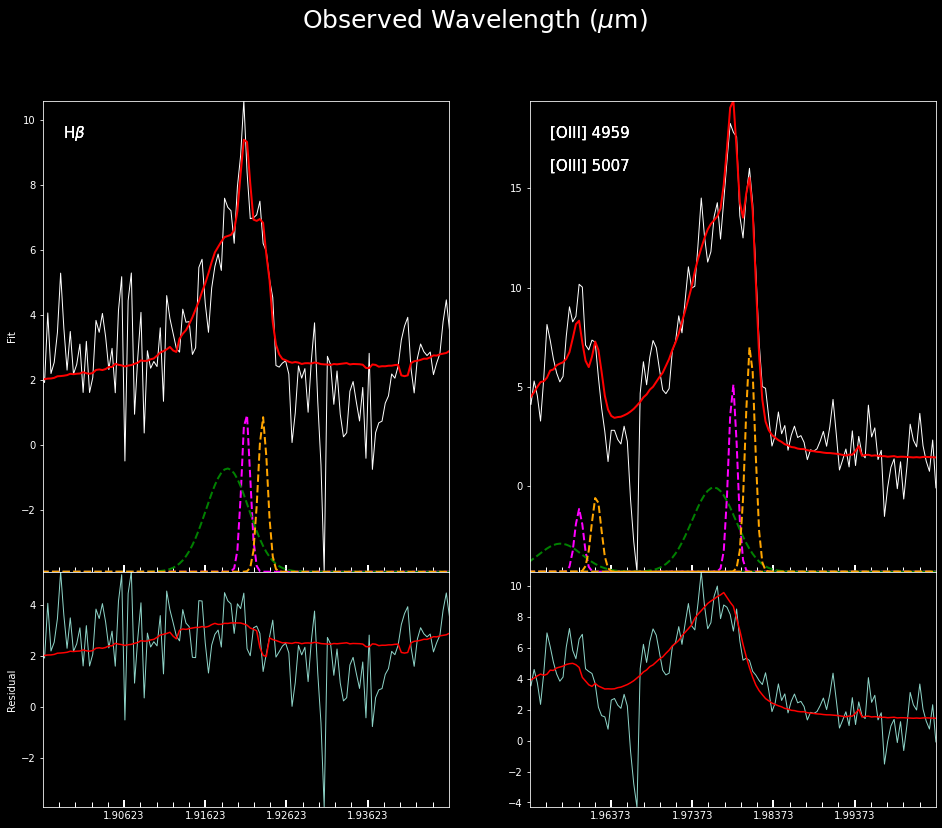

In [36]:
q3do.plot_line(plotargs=argsplotline)

The continuum plot can be changed by specifying several parameters. In this case, we have chosen to output a linear/linear plot of f$_\lambda$ vs. wavelength, in $\overset{\circ}{\rm A}$.

In [37]:
argscontplot = dict()
argscontplot['xstyle'] = 'lin'
argscontplot['ystyle'] = 'lin'
argscontplot['fluxunit_out'] = 'flambda'
argscontplot['mode'] = 'dark'

Run two methods. The first computes the continuum values to plot, and the second does the plotting.

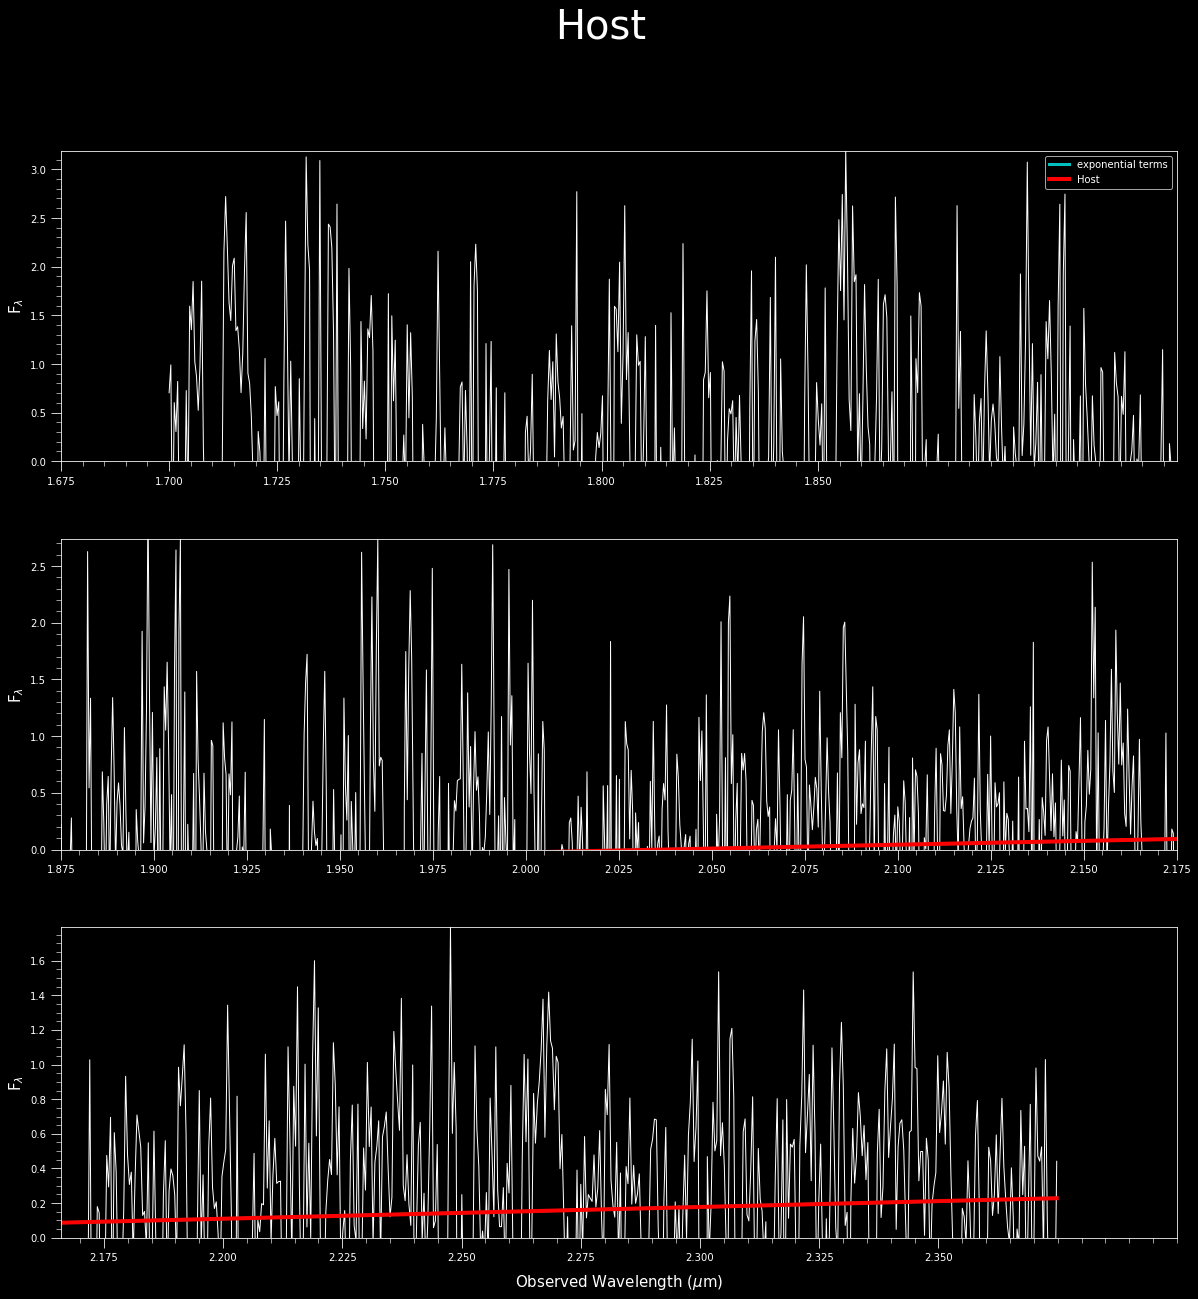

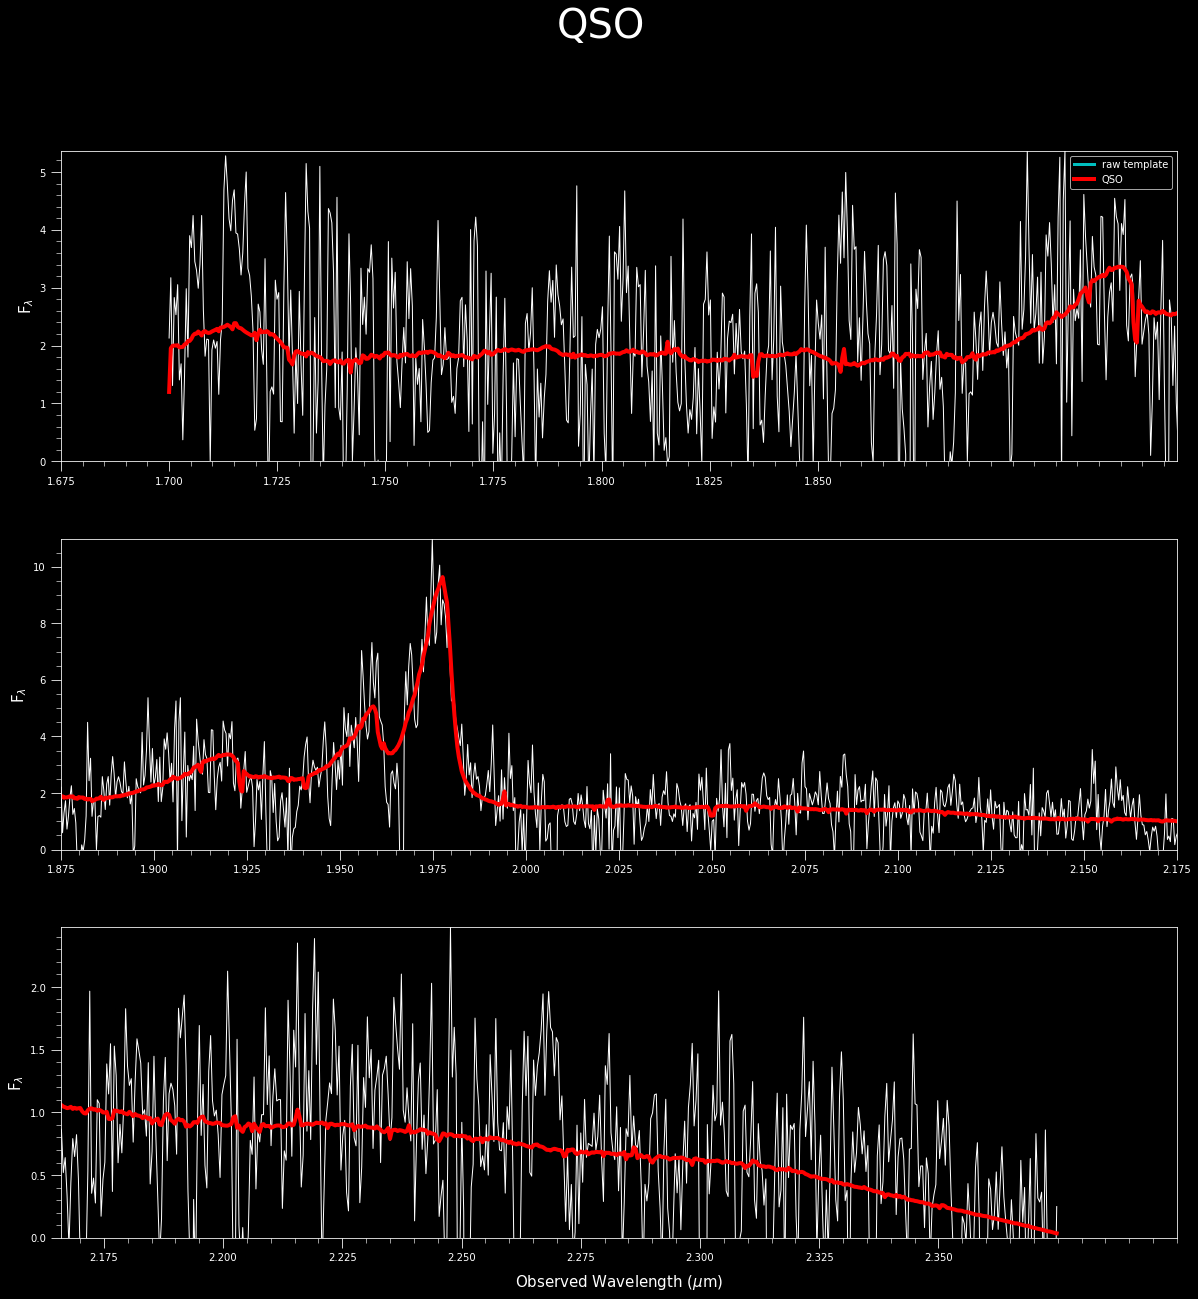

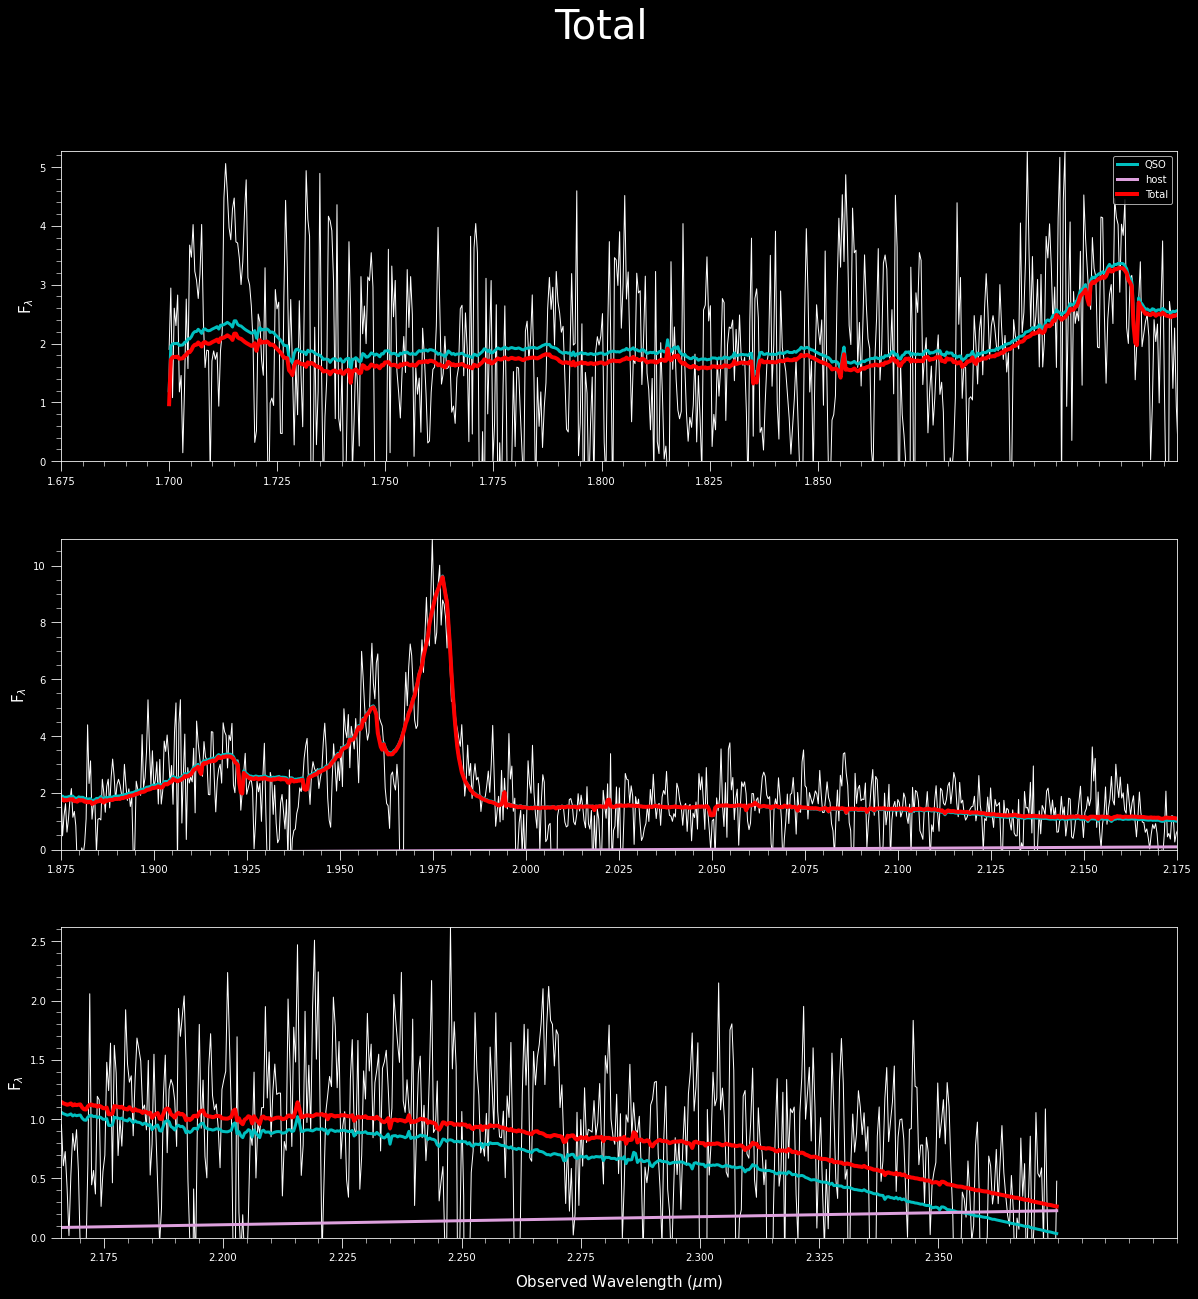

In [38]:
q3do.sepcontpars(q3di)
q3do.plot_cont(q3di, plotargs=argscontplot)

## 4. Combine fit results from all spaxels.<a class="anchor" id="chapter4"></a>

This routine takes all of the spaxels you fit and combines the line- and continuum-fitting results together. The outputs are saved into two files.

In [ ]:
cols = [1, 17]
rows = [1, 26]
from q3dfit.q3dcollect import q3dcollect
q3dcollect(q3di, cols=cols, rows=rows)

## 5. Plot science products. <a class="anchor" id="chapter5"></a>

These routines take the output of `q3dcollect` and compute process them further for science output. The `q3dpro` class has methods to make maps of physical quantities.

In [ ]:
import q3dfit.q3dpro as q3dpro
qpro = q3dpro.Q3Dpro(q3di, PLATESCALE=0.05, NOCONT=True)
do_kpc = False
saveFile = False
flx = [1e-6,1e-4]
qsocenter = None
pltarg = {'Ftot':flx,
          'Fci':flx,
          'Sig':[0,250],
          'v50':[-300,300],
          'w80':[0,500],
          'fluxlog':True,}
line_vacuum = False
qpro = q3dpro.Q3Dpro(q3di)

In [ ]:
qpro.make_linemap('Halpha', XYSTYLE=do_kpc, xyCenter=qsocenter,
                  LINEVAC=line_vacuum, SAVEDATA=saveFile, VMINMAX=pltarg, PLTNUM=1)
#qpro.make_linemap('[NII]6583',XYSTYLE=do_kpc,xyCenter=qsocenter,
#                  LINEVAC=line_vacuum,SAVEDATA=saveFile,VMINMAX=pltarg,PLTNUM=1)
#qpro.make_linemap('Hbeta',XYSTYLE=do_kpc,xyCenter=qsocenter,
#                  LINEVAC=line_vacuum,SAVEDATA=saveFile,VMINMAX=pltarg,PLTNUM=1)

In [ ]:
qpro.make_BPT(SNRCUT=3, LINEVAC=line_vacuum, SAVEDATA=saveFile)

In [ ]:
qpro.make_lineratio_map('Halpha', 'Hbeta', VMINMAX=[0,1])